### Loading packages

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../../..")
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda"

import theano

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np
import pandas as pn
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_ksll66iz.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce RTX 2080 (0000:01:00.0)


### Loading surface points from repository:

With pandas we can do it directly from the web and with the right args we can directly tidy the data in gempy style:

In [2]:
dfs = []

# First stratigraphic data
for letter in range(1,10):
    if letter == 3 or letter ==6 or letter == 8:
        pass
    else:
        dfs.append(pn.read_csv('https://raw.githubusercontent.com/Loop3D/ImplicitBenchmark/master/Hecho/Sparse/H'+
                               str(letter)+'.csv', sep=';',
                             names=['X', 'Y', 'Z', 'surface', '_'], header=0))
# Also faults
for f in range(1,4):
    fault_df = pn.read_csv('https://raw.githubusercontent.com/Loop3D/ImplicitBenchmark/master/Hecho/F'+
                           str(f)+'Line.csv',
                  sep=';', names=['X', 'Y', 'Z'], header=0)
    fault_df['surface'] = 'f'+str(f)
    dfs.append(fault_df)        

# We put all the surfaces points together because is how gempy likes it:
surface_points = pn.concat(dfs, sort=True)
surface_points.reset_index(inplace=True, drop=False)
surface_points.tail()

,index,X,Y,Z,_,surface
402,6,11.143734,-0.172893,1.53226,NaN,f3
403,7,11.171513,0.284198,1.68442,NaN,f3
404,8,11.159113,0.399711,1.81939,NaN,f3
405,9,11.069008,0.032232,1.92030,NaN,f3
406,10,10.885192,-0.428004,2.10412,NaN,f3


Now we do the same with the orientations:

In [3]:
orientations = pn.read_csv('https://raw.githubusercontent.com/Loop3D/ImplicitBenchmark/master/Hecho/Sparse/Dips.csv', sep=';',
                names=['X', 'Y', 'Z', 'G_x', 'G_z', '_'], header=0)
# Orientation needs to belong to a surface. This is mainly to categorize to which series belong and to
# use the same color
orientations['surface'] = 0

# We fill the laking direction with a dummy value:
orientations['G_y'] = 0

# Drop unecesary data point
orientations.drop([1,3,4], inplace=True)
orientations

,X,Y,Z,G_x,G_z,_,surface,G_y
0,3.812638,0.163828,0.584748,0.619147,0.785275,4,0,0
2,9.870857,0.058731,2.520195,-0.764469,0.644660,20,0,0
5,4.831136,-0.031274,3.328896,0.067834,0.997697,28,0,0


### Data initialization:

Suggested size of the axis-aligned modeling box: Origin: 0 -0.5 0 Maximum: 16 0.5 4.5

Suggested resolution: 0.05m (grid size 321 x 21 x 91)

In [4]:
geo_model = gp.create_model('Moureze')
geo_model = gp.init_data(geo_model, extent= [0, 16, -0.5, 0.5, 0, 4.5], resolution=[321, 21, 91],
                         surface_points_df=surface_points, orientations_df=orientations,
                         surface_name='surface',
                         add_basement=True)

Active grids: ['regular']


/home/miguel/.conda/envs/m_gempy/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


We need an orientation per series/fault. The faults does not have orientation so the easiest is to create an orientation from the surface points availablle:

In [5]:
f_names = ['f1','f2','f3']
for fn in f_names:
    fault_idx = geo_model.surface_points.df.index[geo_model.surface_points.df['surface'] ==fn]
    gp.set_orientation_from_surface_points(geo_model, fault_idx)

../../../gempy/core/data.py:1675: UserWarning: If pole_vector and orientation are passed pole_vector is used/
  warnings.warn('If pole_vector and orientation are passed pole_vector is used/')


Now we can see how the data looks so far:

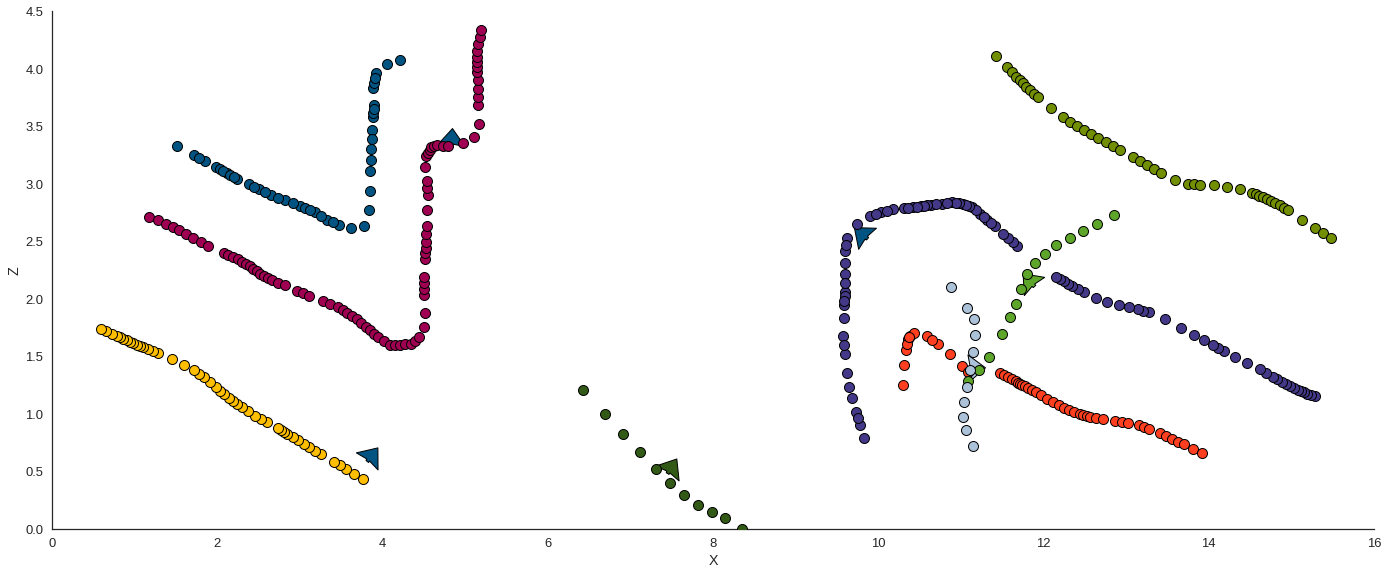

In [6]:
gp.plot.plot_data(geo_model)

By default all surfaces belong to one unique series.

In [7]:
geo_model.surfaces

,surface,series,order_surfaces,isBasement,color,id
0,0,Default series,1,False,#015482,1
1,0.78,Default series,2,False,#9f0052,2
2,1.9,Default series,3,False,#ffbe00,3
3,2.5,Default series,4,False,#728f02,4
4,3.9,Default series,5,False,#443988,5
5,5.2,Default series,6,False,#ff3f20,6
6,f1,Default series,7,False,#325916,7
7,f2,Default series,8,False,#5DA629,8
8,f3,Default series,9,False,#acc2d9,9
9,basement,Basement,1,True,#56ae57,10


We will need to separate with surface belong to each series:

In [8]:
gp.map_series_to_surfaces(geo_model, {'Fault1':'f1', 'Fault2':'f2', 'Fault3':'f3'})

,surface,series,order_surfaces,isBasement,color,id
0,0,Default series,1,False,#015482,1
1,0.78,Default series,2,False,#9f0052,2
2,1.9,Default series,3,False,#ffbe00,3
3,2.5,Default series,4,False,#728f02,4
4,3.9,Default series,5,False,#443988,5
5,5.2,Default series,6,False,#ff3f20,6
6,f1,Fault1,1,False,#325916,7
7,f2,Fault2,1,False,#5DA629,8
8,f3,Fault3,1,False,#acc2d9,9
9,basement,Basement,1,True,#56ae57,10


However if we want the faults to offset the "Default series", they will need to be more recent (higher on the pile). We can modify the order by:

In [9]:
geo_model.modify_order_series(4, 'Default series')

,order_series,BottomRelation
Fault3,1,Erosion
Fault1,2,Erosion
Fault2,3,Erosion
Default series,4,Erosion
Basement,5,Erosion


Lastly, so far we did not specify which series/faults are actula faults:

In [10]:
geo_model.set_is_fault(['Fault1', 'Fault2', 'Fault3'])

Fault colors changed. If you do not like this behavior, set change_color to False.


,isFault,isFinite
Fault3,True,False
Fault1,True,False
Fault2,True,False
Default series,False,False
Basement,False,False


Now we are good to go:

In [11]:
gp.set_interpolation_data(geo_model,theano_optimizer='fast_run', dtype='float32')

Compiling theano function...
Level of Optimization:  fast_run
Device:  cuda
Precision:  float32
Number of faults:  3
Compilation Done!


The default range is always the diagonal of the extent. Since in this model data is very close we will need to reduce the range to 5-10% of that value:

In [12]:
geo_model.interpolator.theano_graph.a_T.get_value()
geo_model.interpolator.theano_graph.a_T.set_value(.2)

In [23]:
gp.compute_model(geo_model, sort_surfaces=True, compute_mesh=False)


Lithology ids 
  [10. 10. 10. ...  6.  6.  6.] 

### Time
- GTX 2080 164 ms ± 2.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


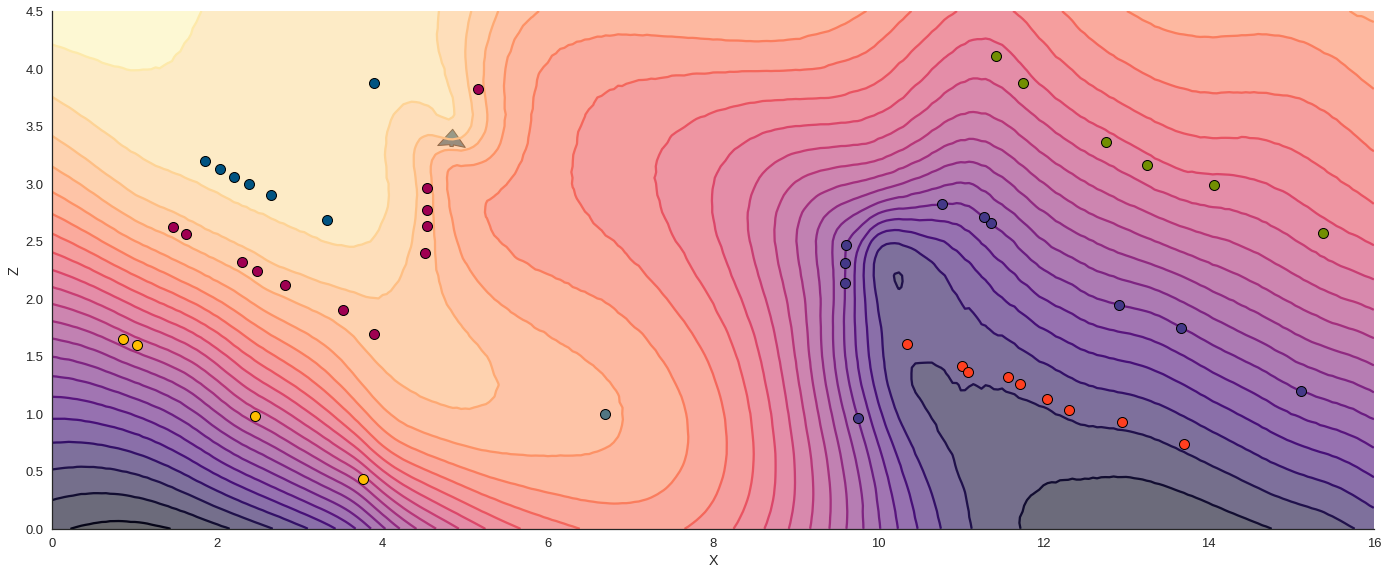

In [21]:
gp.plot.plot_scalar_field(geo_model, 10, series=3)

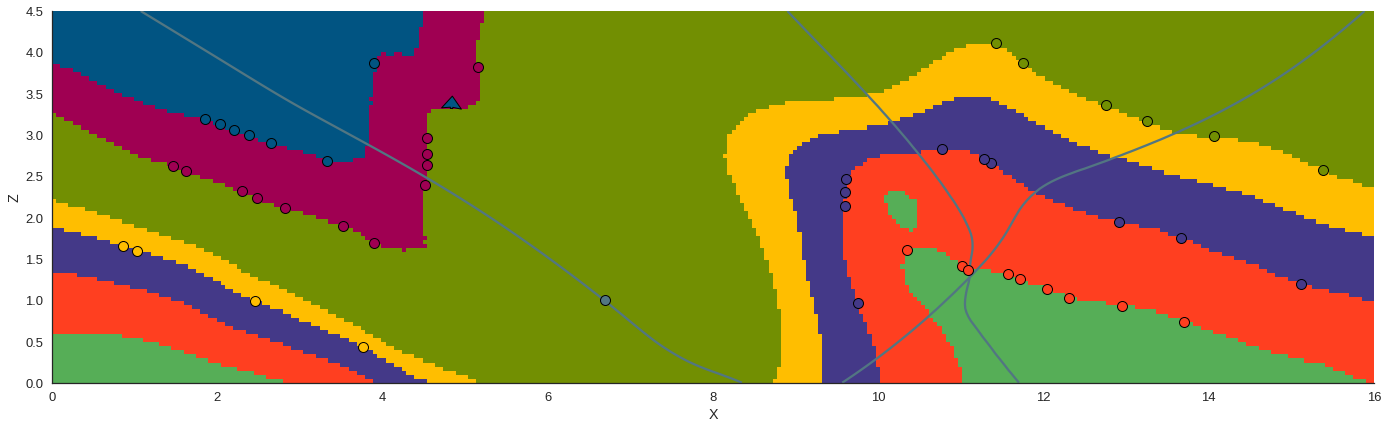

In [22]:
gp.plot.plot_section(geo_model, 10,  show_faults=True, show_data=True)

In [16]:
# gp.plot.plot_3D(geo_model)

### Export data:

The solution is stored in a numpy array of the following shape. Axis 0 are the scalar fields of each correspondent series/faults in the following order (except basement): 

In [17]:
geo_model.series

,order_series,BottomRelation
Fault3,1,Fault
Fault1,2,Fault
Fault2,3,Fault
Default series,4,Erosion
Basement,5,Erosion


For the surfaces, there are two numpy arrays, one with vertices and the other with triangles. Axis 0 is each surface in the order:

In [18]:
geo_model.surfaces

,surface,series,order_surfaces,isBasement,color,id
8,f3,Fault3,1,False,#527682,1
6,f1,Fault1,1,False,#527682,2
7,f2,Fault2,1,False,#527682,3
0,0,Default series,1,False,#015482,4
1,0.78,Default series,2,False,#9f0052,5
2,1.9,Default series,3,False,#ffbe00,6
3,2.5,Default series,4,False,#728f02,7
4,3.9,Default series,5,False,#443988,8
5,5.2,Default series,6,False,#ff3f20,9
9,basement,Basement,1,True,#56ae57,10


In [24]:
np.save('Hecho_scalar', geo_model.solutions.scalar_field_matrix)